# Introduction

[Animate objects](https://roll20.net/compendium/dnd5e/Animate%20Objects#content) is a 5-th level spell available to Wizards, Sorcerers, and Bards.
> Objects come to life at your Command. Choose up to ten nonmagical Objects within range that are not being worn or carried. Medium Targets count as two Objects, Large Targets count as four Objects, Huge Targets count as eight Objects. You can't animate any object larger than Huge. Each target animates and becomes a creature under your control until the spell ends or until reduced to 0 Hit Points.

Animated objects can do a lot of things, but I'm interested in using them as a weapon.

##### Imports

In [72]:
from itertools import combinations_with_replacement
import sys
sys.path.append('drive/MyDrive')

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from dndrv import D4, D6, D8, D10, D12, D20, d20_outcome


sns.set()

## Object stats

The objects have different combat characteristics depending on their sizes:

|        | Attack bonus | Damage   | Cost |
|-------:|:------------:|:---------|:----:|
| Tiny   | 8            | 1d4 + 4  | 1    |
| Small  | 6            | 1d8 + 2  | 1    |
| Medium | 5            | 2d6 + 1  | 2    |
| Large  | 6            | 2d10 + 2 | 4    |
| Huge   | 8            | 2d12 + 4 | 8    |

The `Cost` column stands for this part of the spell description:
> Medium Targets count as two Objects, Large Targets count as four Objects, Huge Targets count as eight Objects.

## Possible combinations of sizes of Animated objects

There is a variety of ways to spend 10 points on objects of different sizes. Let's find out combinations of sizes that use *all* 10 points.

In [2]:
sizes = ['Tiny', 'Small', 'Medium', 'Large', 'Huge']
values = [1, 1, 2, 4, 8]

cost = dict(zip(sizes, values))
possible_subsets = []

for subset_len in range(1, 11):
  for subset in combinations_with_replacement(sizes, subset_len):
    total = 0
    for size in subset:
      total += cost[size]
      if total > 10:
        break
    if total == 10:
      possible_subsets.append(subset)

print('The number of all possible combinations of animated objects:', len(possible_subsets))

60

# Calculating distributions and averages

The random variable for damage dealt by each of the objects can be calculated like this:
$$
  DMG = R^{\{0, 1\}}_{hit}
        \cdot
        \left(
          dmg + R^{\{0, 1\}}_{(crit|hit)} \cdot dmg
        \right)
$$
where:
* $R^{\{0, 1\}}_{hit}$ &mdash; a binary (0 or 1) random variable of having success on an attack. Its probability distribution depends on target's Armor Class and the object's attack bonus.
* $dmg$ &mdash; a random variable of object's damage. Different for different sizes of objects.
* $R^{\{0, 1\}}_{(crit|hit)}$ &mdash; a binary random variable of having a critical hit on a succesful attack.

According to Monster Manual, monster's Armor Class can be from 5 to 25. I'm going to calculate average damages for each of them.

In [3]:
dmg = {
    'Tiny' : D4 + 4
    , 'Small' : D8 + 2
    , 'Medium' : sum([D6] * 2) + 1
    , 'Large' : sum([D10] * 2) + 2
    , 'Huge' : sum([D12] * 2) + 4
}

atk_bonus = {
    'Tiny' : 8
    , 'Small' : 6
    , 'Medium' : 5
    , 'Large' : 6
    , 'Huge' : 8    
}

In [13]:
rows = []
for ac in range(5, 26):
  for subset in possible_subsets:
    dmg_rv_list = []
    for object_size in subset:
      to_hit, crit_rv = d20_outcome(D20
                                    , threshold=ac
                                    , modifier=atk_bonus[object_size]
                                    , crit_fail_values=[1]
                                    , crit_success_values=[20]
                                    , return_critical=True
                                  )
      dmg_rv_list.append(
          to_hit * (dmg[object_size] + crit_rv*dmg[object_size])
      )

      # Produce more palatable id for the subset:
      c_u = []
      for u, c in zip(*np.unique(subset, return_counts=True)):
        c_u.append(f'{c} {u}')
      subset_id = ', '.join(c_u)

    dmg_dist = sum(dmg_rv_list)
    rows.append([ac, subset_id, round(dmg_dist.mean(), 3), dmg_dist.std()])

In [15]:
df = pd.DataFrame(rows, columns=['AC', 'Size combo', 'mean', 'std'])
df.head()

,AC,Size combo,mean,std
0,5,"1 Huge, 1 Medium",25.0,8.060190
1,5,"1 Huge, 2 Tiny",30.0,7.980184
2,5,"1 Huge, 1 Small, 1 Tiny",30.0,8.226988
3,5,"1 Huge, 2 Small",30.0,8.466601
4,5,"2 Large, 1 Medium",34.0,8.890069


# The best size combination for each AC

For each AC, find the combination with the highest mean. If equal, choose the one with lower standard deviation.

In [55]:
df['rank'] = df.groupby(['AC', 'mean'])['std'].rank()
(
  df.groupby('AC')
    .apply(lambda x: x[(x['mean'] == x['mean'].max())
                        & (x['rank'] == 1.0)
                      ]
          )
    .reset_index(level=1)
    ['Size combo']
    .to_frame()
)

,Size combo
AC,
5,10 Tiny
6,10 Tiny
7,10 Tiny
8,10 Tiny
9,10 Tiny
10,10 Tiny
11,10 Tiny
12,10 Tiny
13,10 Tiny


10 tiny objects for the win.

## Average damage dealt by 10 tiny animated objects

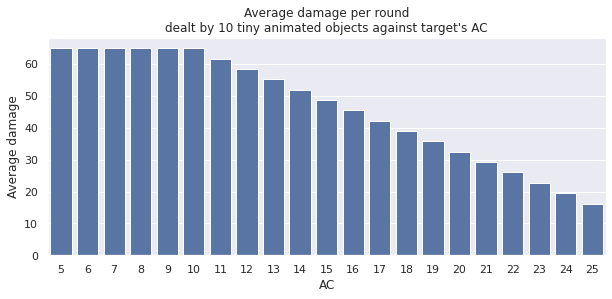

In [79]:
plt.figure(figsize=(10, 4))
ax = sns.barplot(data=df[df['Size combo'] == '10 Tiny']
            , x='AC'
            , y='mean'
            , color='b'
)
plt.title('Average damage per round dealt by 10 tiny animated objects')
ax.set_title('Average damage per round\n'
             'dealt by 10 tiny animated objects against target\'s AC'
            )
ax.set_ylabel('Average damage')
plt.show()

## Bonus: heatmap of average damage for all object combinations and for all ACs

In [81]:
ac_size_df = pd.pivot_table(df
                            , values='mean'
                            , columns='Size combo'
                            , index='AC'
                           ).sort_values(list(range(5, 26)), axis='columns')

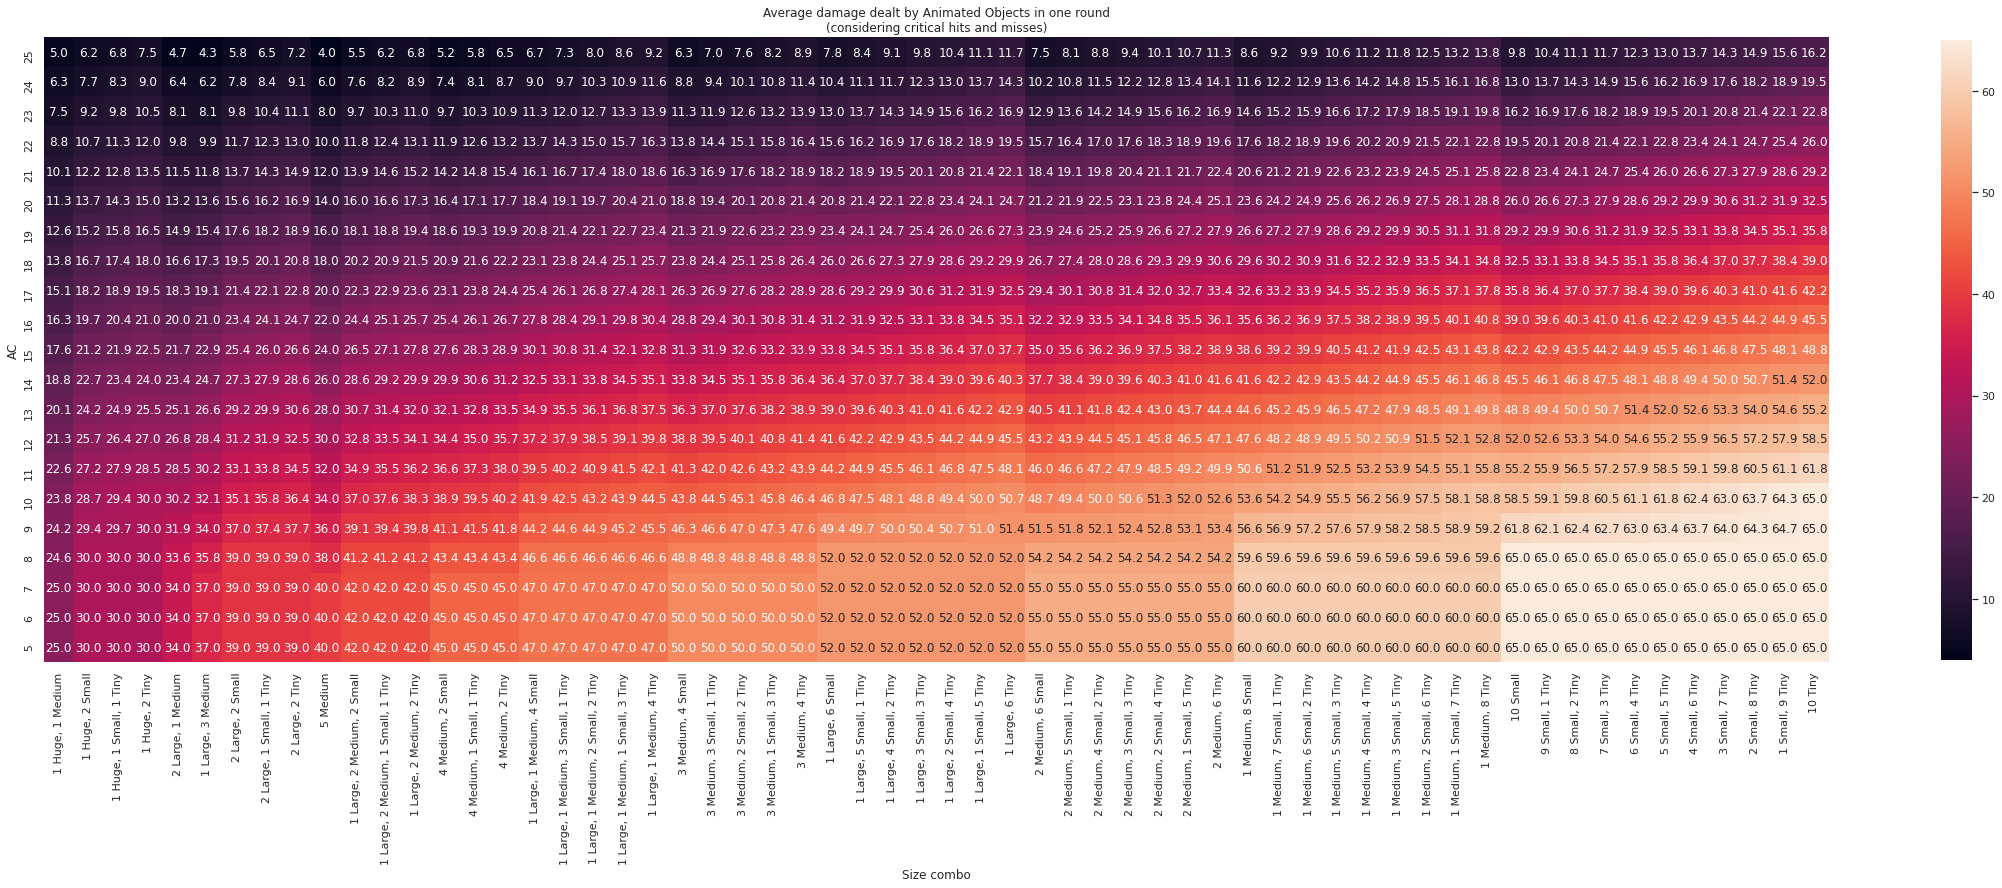

In [82]:
plt.figure(figsize=(40, 20))

sns.heatmap(data=ac_size_df.loc[::-1]
            , square=True
            , annot=True
            , fmt='.1f'
            , cbar_kws={'shrink': 0.57}
           )
plt.title('Average damage dealt by Animated Objects in one round\n'
          '(considering critical hits and misses)'
         )
plt.show()